In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from scipy.cluster import hierarchy
from skimage import io
from collections import defaultdict
import numpy as np
import superpixels as sp
import plot as pl
import process_ground_truth as pgt
import glob
import eval_boundary as ev

In [3]:
ground_path = 'BSDS500/data/groundTruth/train/'
train_path = 'BSDS500/data/images/train/'

### Define parameters for process_image

Just run if you need to (it take a long time)

BSDS500/data/images/train/65132.jpg
Max precision:  0.252566915314
Max index:  1
Best slic:  896
Best felz: 1024


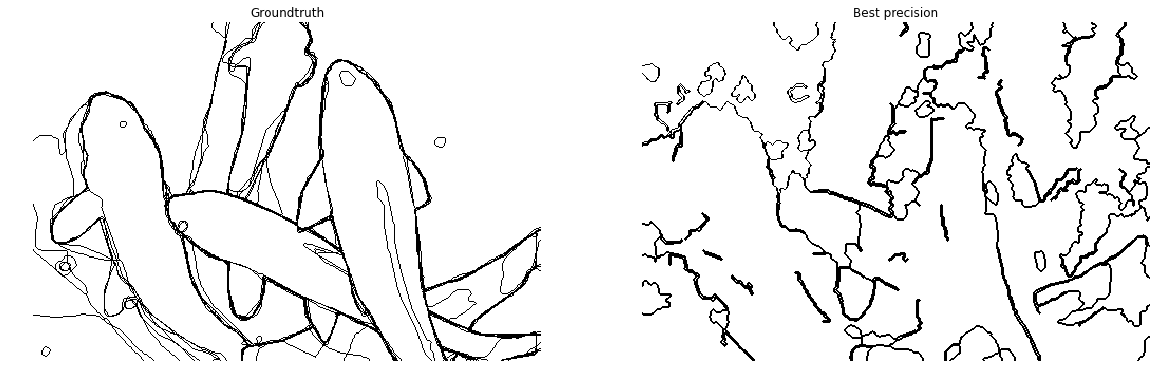

In [49]:
len_ground = len(ground_path)
ground_files = glob.glob(ground_path + '*.mat')
ground_filenames = [x[len_ground:-4] for x in ground_files]

index_filename = int(np.random.rand() * len_ground)

for filename in ground_filenames[index_filename-1:index_filename]:
    ground_file = ground_path + filename + '.mat'
    train_file = train_path + filename + '.jpg'
    
    groundtruth = pgt.get_groundTruth(ground_file)
    image = img_as_float(io.imread(train_file))
    
    best_precision, best_index = 0.0, 0.0
    best_slic, best_felz = 0, 0
    
    for slic_index in range(512, 1024, 128):
        for felz_index in range(1024, 2048, 128):
            _, fs_borders, fs_ultrametric = sp.process_image(image
                                                              , slic_segments = slic_index
                                                              , felz_scale = felz_index
                                                              , felz_min_size = 30
                                                              , save=False)

            len_ultra = len(fs_ultrametric)

            for i in range(len_ultra-1, 0, -1):       
                fs_ultra = fs_ultrametric[i][:, :, 0:1]
                precision, recall = ev.eval_bound(groundtruth, fs_ultra, 0)

                if precision > best_precision:
                    best_precision = precision
                    best_index = i
                    best_slic = slic_index
                    best_felz = felz_index

                    
    _, fs_borders, fs_ultrametric = sp.process_image(image
                                                      , slic_segments = best_slic
                                                      , felz_scale = best_felz
                                                      , felz_min_size = 30
                                                      , save=False)
                    
    print(train_file)
    print('Max precision: ', best_precision)
    print('Max index: ', best_index)
    print('Best slic: ', best_slic)
    print('Best felz:', best_felz)
    
    ground_image = np.zeros(image.shape,dtype=np.uint8)
    for i in range(0,3):
        ground_image[:, :, i] = groundtruth[:, :, 0]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 20))
    ax1.imshow(ground_image)
    ax1.set_title("Groundtruth")
    ax1.set_axis_off()
    ax2.imshow(fs_ultrametric[best_index])
    ax2.set_title("Best precision")
    ax2.set_axis_off()
    plt.show() 

### Compare results with other methods

In [4]:
len_ground = len(ground_path)
ground_files = glob.glob(ground_path + '*.mat')
ground_filenames = [x[len_ground:-4] for x in ground_files]

images = []
groundtruths = []

ini = 0
fim = 10 #len_ground

#load images
for filename in ground_filenames[ini:fim]:
    ground_file = ground_path + filename + '.mat'
    train_file = train_path + filename + '.jpg'
    
    #read groundtruth and image
    groundtruth = pgt.get_groundTruth(ground_file)
    image = img_as_float(io.imread(train_file))
    
    #append image and groundtruths
    groundtruths.append(groundtruth)
    images.append(image)

In [49]:
img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)

fs_borders, f_borders, s_borders = [], [], []

#test values for slic, felz and slic+felz
for groundtruth, image in zip(groundtruths[ini:fim], images[ini:fim]):
    #slic+felz
    _, border, _ = sp.process_image(image
                                        , slic_segments = 896
                                        , felz_scale = 1024
                                        , felz_min_size = 20
                                        , ultrametric = False
                                        , save=False)
    
    img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
    img.fill(255)
    
    #felz
    f_segs = felzenszwalb(image, scale=300, sigma=0.8, min_size=20)
    f_border = mark_boundaries(img, f_segs, color=(0, 0, 0))
    
    #slic
    s_segs = slic(image, n_segments = 300, slic_zero = True) #300 ou 100
    s_border = mark_boundaries(img, s_segs, color=(0, 0, 0))
    
    fs_borders.append(fs_border[:, :, 0:1])
    f_borders.append(f_border[:, :, 0:1])
    s_borders.append(s_border[:, :, 0:1])

In [51]:
fs_precs, f_precs, s_precs = [], [], []
fs_recall, f_recall, s_recall = [], [], []

threshold = 0

for groundtruth, fs_bor, f_bor, s_bor in zip(groundtruths[ini:fim], fs_borders, f_borders, s_borders):    
    #eval precision
    prec_fs, rec_fs = ev.eval_bound(groundtruth, fs_bor, threshold, True)
    prec_f, rec_f = ev.eval_bound(groundtruth, f_bor, threshold, True)
    prec_s, rec_s = ev.eval_bound(groundtruth, s_bor, threshold, True)
    
    #append results
    fs_precs.append(prec_fs)
    f_precs.append(prec_f)
    s_precs.append(prec_s)
    
    fs_recall.append(rec_fs)
    f_recall.append(rec_f)
    s_recall.append(rec_s)

In [52]:
max_fs_precs = np.max(fs_precs)
avg_fs_precs = np.average(fs_precs)
max_f_precs = np.max(f_precs)
avg_f_precs = np.average(f_precs)
max_s_precs = np.max(s_precs)
avg_s_precs = np.average(s_precs)

max_fs_recall = np.max(fs_recall)
avg_fs_recall = np.average(fs_recall)
max_f_recall = np.max(f_recall)
avg_f_recall = np.average(f_recall)
max_s_recall = np.max(s_recall)
avg_s_recall = np.average(s_recall)

max_fs_fmeasure = 2 * ((max_fs_precs * max_fs_recall) / (max_fs_precs + max_fs_recall))
avg_fs_fmeasure = 2 * ((avg_fs_precs * avg_fs_recall) / (avg_fs_precs + avg_fs_recall))
max_f_fmeasure = 2 * ((max_f_precs * max_f_recall) / (max_f_precs + max_f_recall))
avg_f_fmeasure = 2 * ((avg_f_precs * avg_f_recall) / (avg_f_precs + avg_f_recall))
max_s_fmeasure = 2 * ((max_s_precs * max_s_recall) / (max_s_precs + max_s_recall))
avg_s_fmeasure = 2 * ((avg_s_precs * avg_s_recall) / (avg_s_precs + avg_s_recall))

print('Precision MAX')
print('SLIC-EGB:', max_fs_precs, 'EGB:', max_f_precs, 'SLIC:', max_s_precs)
print('Precision AVG')
print('SLIC-EGB:', avg_fs_precs, 'EGB:', avg_f_precs, 'SLIC:', avg_s_precs)

print()
print('Recall MAX')
print('SLIC-EGB:', max_fs_recall, 'EGB:', max_f_recall, 'SLIC:', max_s_recall)
print('Recall AVG')
print('SLIC-EGB:', avg_fs_recall, 'EGB:', avg_f_recall, 'SLIC:', avg_s_recall)

print()
print('F-measure MAX')
print('SLIC-EGB:', max_fs_fmeasure, 'EGB:', max_f_fmeasure, 'SLIC:', max_s_fmeasure)
print('F-measure AVG')
print('SLIC-EGB:', avg_fs_fmeasure, 'EGB:', avg_f_fmeasure, 'SLIC:', avg_s_fmeasure)

Precision MAX
SLIC-EGB: 0.537452415813 EGB: 0.638418740849 SLIC: 0.383153624426
Precision AVG
SLIC-EGB: 0.317098450627 EGB: 0.449520438001 SLIC: 0.286012586852

Recall MAX
SLIC-EGB: 0.373337130304 EGB: 0.301540759592 SLIC: 0.2252786341
Recall AVG
SLIC-EGB: 0.241255051852 EGB: 0.182191098235 SLIC: 0.124106470379

F-measure MAX
SLIC-EGB: 0.440608795852 EGB: 0.409611843836 SLIC: 0.283733559329
F-measure AVG
SLIC-EGB: 0.274025694506 EGB: 0.259291203597 SLIC: 0.173101015484


In [ ]:
np_fs_precs = (np.array(fs_precs))
np_fs_recall = (np.array(fs_recall))

np_f_precs = (np.array(f_precs))
np_f_recall = (np.array(f_recall))

np_s_precs = (np.array(s_precs))
np_s_recall = (np.array(s_recall))

fs_fmeasure = 2 * ((np_fs_precs * np_fs_recall) / (np_fs_precs + np_fs_recall))
f_fmeasure = 2 * ((np_f_precs * np_f_recall) / (np_f_precs + np_f_recall))
s_fmeasure = 2 * ((np_s_precs * np_s_recall) / (np_s_precs + np_s_recall))

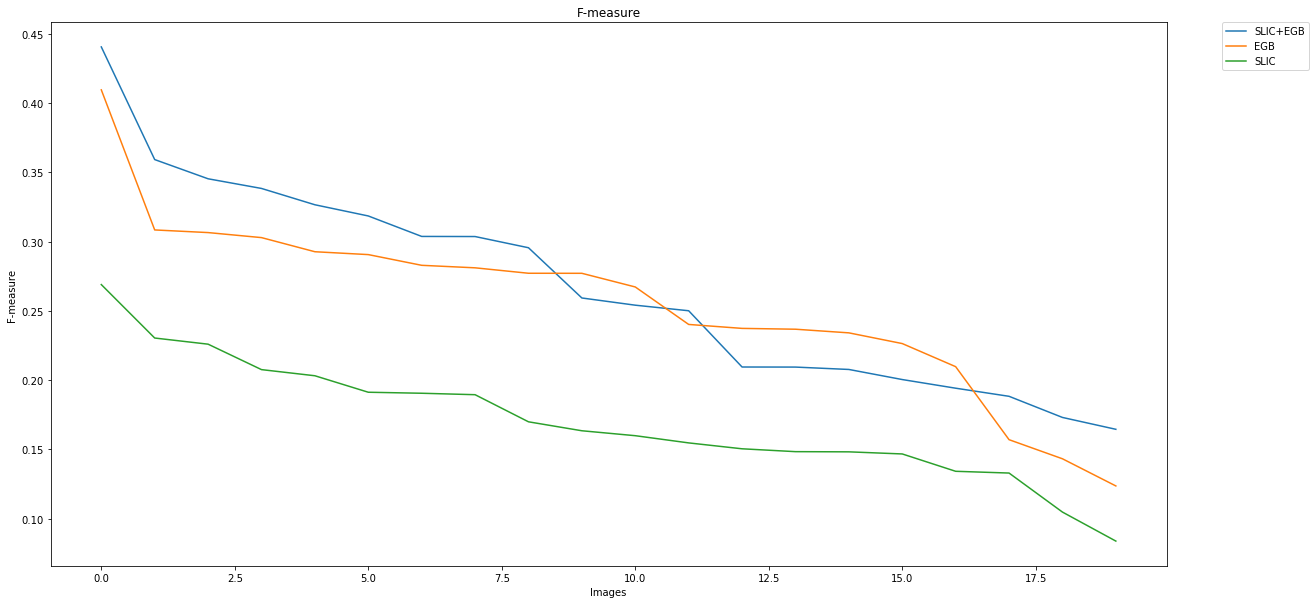

In [65]:
#plot curves
plt.figure(figsize=(20,10))
plt.plot(np.sort(fs_fmeasure)[::-1], label='SLIC+EGB')
plt.plot(np.sort(f_fmeasure)[::-1], label='EGB')
plt.plot(np.sort(s_fmeasure)[::-1], label='SLIC')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Images')
plt.ylabel('F-measure')
plt.title('F-measure')
plt.show()